In [1]:
import torch
import sys
sys.path.append("/home/onyxia/work/Advanced-ML")
from data import S3ParquetReader
from config import USER
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from models import AutoEncoder, train_model, CombinedLoss
from torch.optim import Adam
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# Data Loading

In [2]:
# load data from s3 storage
BUCKET = f"/{USER}/jane_street_data"
reader = S3ParquetReader(bucket=BUCKET)
FILE_KEY_S3 = "preprocessed.parquet/data_clean_symb_1.parquet"

data = reader.read_parquet(FILE_KEY_S3)
data.head()

date_id,feature_05,feature_06,feature_07,feature_08,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_22,feature_23,feature_24,feature_25,feature_28,feature_29,feature_30,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_40,feature_41,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,…,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_responder_0_lagged,feature_responder_1_lagged,feature_responder_2_lagged,feature_responder_3_lagged,feature_responder_4_lagged,feature_responder_5_lagged,feature_responder_6_lagged,feature_responder_7_lagged,feature_responder_8_lagged,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8,symbol_id,time_id,weight
i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i16,f32
0,0.127298,0.339121,-0.045494,0.151473,-0.038995,-0.644192,-0.193971,-0.016662,-0.213108,-0.045016,0.014899,0.128033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.397016,0.694868,0.812098,-0.128621,0.025559,0.018694,-0.006306,-1.706433,-0.490941,0.425017,0.281025,-0.134582,0.046605,-0.059343,-0.751958,-0.314242,…,0.085259,-0.324355,-0.097414,-0.296044,0.21344,-0.20025,-0.11987,-0.007101,-0.693186,-0.181427,0.073886,-0.062266,0.136151,0.110356,0.055748,-0.028266,0.573992,-0.319932,-0.335376,-0.21128,-0.279558,-0.434355,-1.220439,0.214211,-0.257941,0.36224,-0.376568,-0.086291,-0.392552,-0.267725,-0.112329,-1.233082,0.131704,-0.024239,1,35,3.889038
0,0.114208,-1.419921,-0.505525,-0.258195,0.017889,-0.254385,0.015691,-0.020583,-0.15111,-0.034961,-0.045215,-0.411787,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.037745,-0.824408,-0.312367,0.272155,0.041673,0.051002,0.101001,-0.172871,0.356697,0.43781,-0.243426,0.116691,0.21925,-0.059218,-0.298613,0.029315,…,-0.067586,0.22172,0.347892,0.511532,-0.214167,-0.045423,-0.048534,0.048807,-0.407794,0.008081,-0.071584,0.056597,0.01653,-0.049644,-0.023103,-0.0531,0.36224,-0.376568,-0.086291,-0.392552,-0.267725,-0.112329,-1.233082,0.131704,-0.024239,0.283566,-0.397785,0.041572,0.001317,-0.112683,0.419467,-0.578848,0.269364,0.459819,1,36,3.889038
0,0.118826,-1.293755,-0.809856,0.268584,-0.056675,-0.273341,-0.016404,0.010669,0.172457,0.011381,0.013246,-0.016248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.571682,0.168574,-0.042331,-0.55658,0.175519,-0.052067,0.053939,0.109843,-0.055707,-0.214608,-0.026042,-0.180718,-0.171372,-0.019658,-0.084493,-0.116301,…,-0.100162,-0.029472,0.037072,0.097566,0.061552,-0.136708,-0.029742,-0.047774,-0.150518,-0.287006,-0.000054,-0.048201,-0.093462,-0.015866,0.051347,0.055587,0.283566,-0.397785,0.041572,0.001317,-0.112683,0.419467,-0.578848,0.269364,0.459819,0.260547,-0.299865,0.239627,-0.019651,-0.194262,0.321798,-0.683034,0.027111,0.075722,1,37,3.889038
0,-0.216346,-0.021069,-0.425764,-0.005701,-0.010654,0.302838,0.000491,-0.017648,-0.036415,-0.008958,0.384812,0.49453,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.202302,0.395804,-0.512155,0.642004,0.414221,0.113961,-0.131998,-0.374575,0.206433,-0.445924,-0.518108,0.268771,0.069906,0.207732,-0.046667,-0.266864,…,0.036929,-0.176699,-0.503255,-0.449954,-0.134894,0.050516,-0.089379,0.004014,-0.204778,-0.144482,-0.082102,-0.050271,0.020269,-0.008658,0.096835,-0.042524,0.260547,-0.299865,0.239627,-0.019651,-0.194262,0.321798,-0.683034,0.027111,0.075722,0.423799,-0.195033,0.145029,-0.076218,-0.304814,0.098249,-0.606483,-0.01076,-0.134628,1,38,3.889038
0,-0.660073,2.168059,0.903407,-0.101644,0.133174,-0.212203,-0.217244,0.006182,-0.076704,-0.027879,0.249095,-0.431726,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.511043,-0.221639,-0.014473,-0.

In [3]:
# we pick responder_6 as the target (same target as the data challenge)
target = "responder_6"
features = [col for col in data.columns if "feature" in col]
X, y = data[features], data[target]

n = X.height
n_train = int(0.8 * n)
X_train_raw = X.slice(0, n_train)
y_train_raw = y.slice(0, n_train)
X_val_raw = X.slice(n_train)
y_val_raw = y.slice(n_train)

# Scaling
scaler_x = StandardScaler()
scaler_y = StandardScaler()

# We use .to_numpy() for the scalers
x_train_np = scaler_x.fit_transform(X_train_raw.to_numpy())
# Important: y must be 2D for the scaler
y_train_np = scaler_y.fit_transform(y_train_raw.to_numpy().reshape(-1, 1))

x_val_np = scaler_x.transform(X_val_raw.to_numpy())
y_val_np = scaler_y.transform(y_val_raw.to_numpy().reshape(-1, 1))

# Dataset Class
class TimeSeriesDataset(Dataset):
    def __init__(self, X_np, y_np):
        # We store them as tensors directly to avoid re-converting at each __getitem__
        self.X = torch.tensor(X_np, dtype=torch.float32)
        self.y = torch.tensor(y_np, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Instantiation
train_dataset = TimeSeriesDataset(x_train_np, y_train_np)
val_dataset = TimeSeriesDataset(x_val_np, y_val_np)

# Loader
train_data_loader = DataLoader(train_dataset, batch_size=2048, shuffle=True, num_workers=0)
val_data_loader = DataLoader(val_dataset, batch_size=2048, shuffle=False, num_workers=0)

# Models Evaluation


--- Training with alpha = 0 ---


  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:15<02:23, 15.92s/it]

Epoch 01 | loss=430.230 | R2_rec_train=-0.0505 | R2_rec_val=-0.1711 | R2_sup_train=0.2598 | R2_sup_val=0.7725


 20%|██        | 2/10 [00:31<02:08, 16.01s/it]

Epoch 02 | loss=101.039 | R2_rec_train=-0.1590 | R2_rec_val=-0.1850 | R2_sup_train=0.8263 | R2_sup_val=0.8201


 30%|███       | 3/10 [00:47<01:51, 15.89s/it]

Epoch 03 | loss=98.551 | R2_rec_train=-0.1596 | R2_rec_val=-0.1709 | R2_sup_train=0.8306 | R2_sup_val=0.8425


 40%|████      | 4/10 [01:03<01:35, 15.85s/it]

Epoch 04 | loss=97.616 | R2_rec_train=-0.1570 | R2_rec_val=-0.1803 | R2_sup_train=0.8323 | R2_sup_val=0.8447


 50%|█████     | 5/10 [01:19<01:19, 15.85s/it]

Epoch 05 | loss=96.744 | R2_rec_train=-0.1651 | R2_rec_val=-0.1926 | R2_sup_train=0.8337 | R2_sup_val=0.8424


 60%|██████    | 6/10 [01:36<01:04, 16.19s/it]

Epoch 06 | loss=96.363 | R2_rec_train=-0.1707 | R2_rec_val=-0.2032 | R2_sup_train=0.8344 | R2_sup_val=0.8467


 70%|███████   | 7/10 [01:52<00:49, 16.36s/it]

Epoch 07 | loss=96.178 | R2_rec_train=-0.1764 | R2_rec_val=-0.2087 | R2_sup_train=0.8347 | R2_sup_val=0.8444


 80%|████████  | 8/10 [02:09<00:32, 16.31s/it]

Epoch 08 | loss=95.815 | R2_rec_train=-0.1886 | R2_rec_val=-0.2443 | R2_sup_train=0.8354 | R2_sup_val=0.8411


 90%|█████████ | 9/10 [02:25<00:16, 16.24s/it]

Epoch 09 | loss=95.669 | R2_rec_train=-0.2004 | R2_rec_val=-0.2459 | R2_sup_train=0.8356 | R2_sup_val=0.8363


100%|██████████| 10/10 [02:41<00:00, 16.15s/it]

Epoch 10 | loss=95.597 | R2_rec_train=-0.2145 | R2_rec_val=-0.2589 | R2_sup_train=0.8357 | R2_sup_val=0.8428


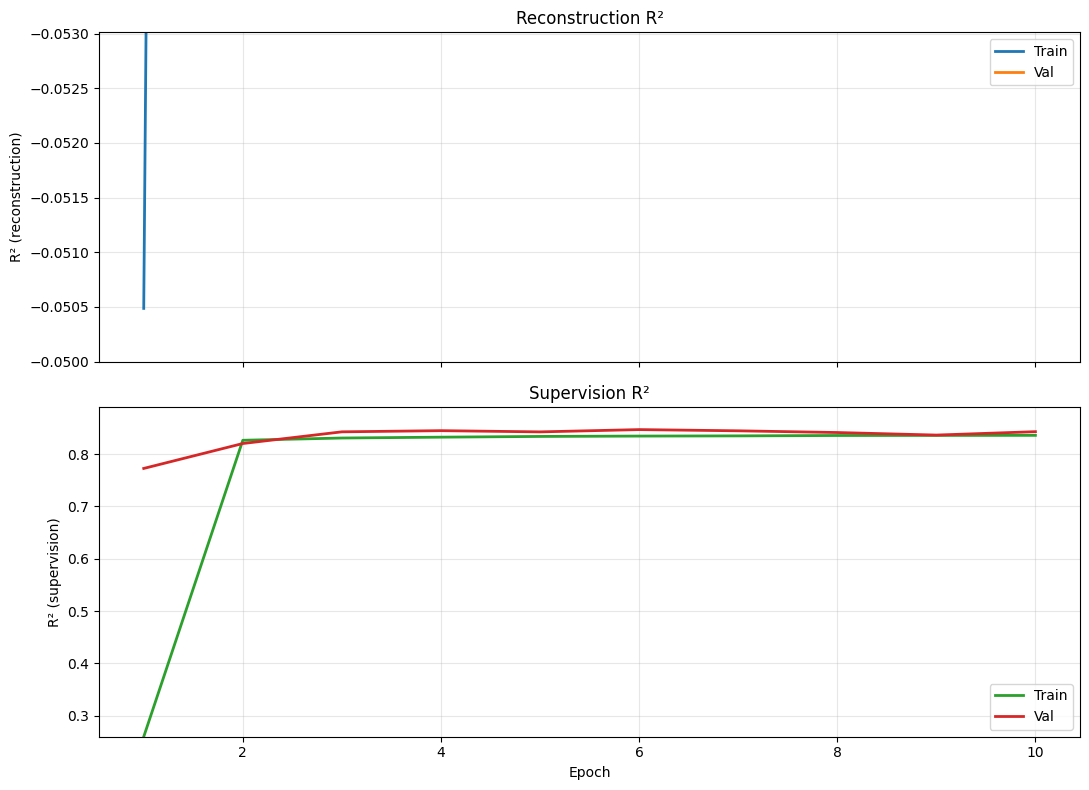


--- Training with alpha = 0.01 ---


 10%|█         | 1/10 [00:15<02:21, 15.68s/it]

Epoch 01 | loss=197.486 | R2_rec_train=0.1716 | R2_rec_val=0.0899 | R2_sup_train=0.6688 | R2_sup_val=0.7255


 20%|██        | 2/10 [00:30<02:02, 15.30s/it]

Epoch 02 | loss=131.720 | R2_rec_train=0.2679 | R2_rec_val=0.0483 | R2_sup_train=0.7808 | R2_sup_val=0.7810


 30%|███       | 3/10 [00:45<01:45, 15.09s/it]

Epoch 03 | loss=118.396 | R2_rec_train=0.3108 | R2_rec_val=0.0510 | R2_sup_train=0.8035 | R2_sup_val=0.8049


 40%|████      | 4/10 [01:00<01:30, 15.13s/it]

Epoch 04 | loss=112.165 | R2_rec_train=0.3366 | R2_rec_val=0.1286 | R2_sup_train=0.8138 | R2_sup_val=0.8262


 50%|█████     | 5/10 [01:17<01:17, 15.57s/it]

Epoch 05 | loss=108.701 | R2_rec_train=0.3422 | R2_rec_val=0.1030 | R2_sup_train=0.8197 | R2_sup_val=0.8240


 60%|██████    | 6/10 [01:32<01:01, 15.35s/it]

Epoch 06 | loss=106.629 | R2_rec_train=0.3534 | R2_rec_val=0.1677 | R2_sup_train=0.8234 | R2_sup_val=0.8340


 70%|███████   | 7/10 [01:48<00:46, 15.64s/it]

Epoch 07 | loss=104.994 | R2_rec_train=0.3597 | R2_rec_val=0.1576 | R2_sup_train=0.8261 | R2_sup_val=0.8379


 80%|████████  | 8/10 [02:04<00:31, 15.86s/it]

Epoch 08 | loss=103.749 | R2_rec_train=0.3670 | R2_rec_val=0.1815 | R2_sup_train=0.8281 | R2_sup_val=0.8365


 90%|█████████ | 9/10 [02:20<00:15, 15.84s/it]

Epoch 09 | loss=103.156 | R2_rec_train=0.3705 | R2_rec_val=0.1724 | R2_sup_train=0.8291 | R2_sup_val=0.8326


100%|██████████| 10/10 [02:35<00:00, 15.52s/it]

Epoch 10 | loss=102.385 | R2_rec_train=0.3679 | R2_rec_val=0.2161 | R2_sup_train=0.8304 | R2_sup_val=0.8407


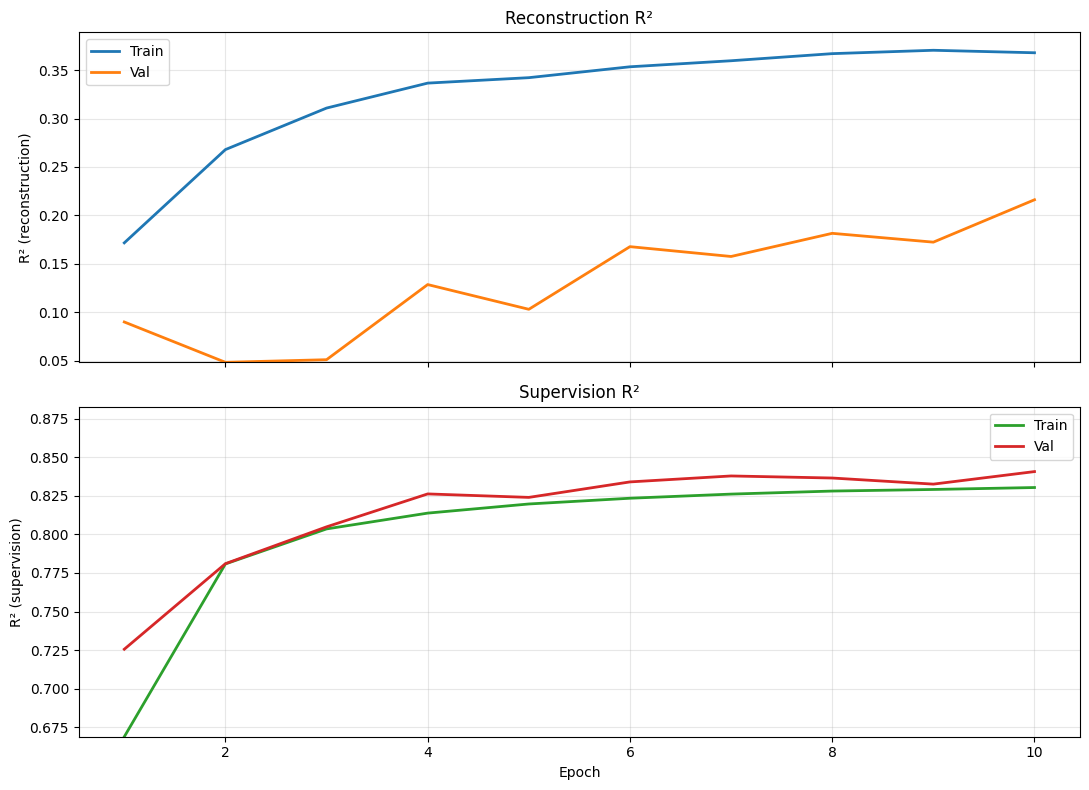


--- Training with alpha = 0.1 ---


 10%|█         | 1/10 [00:15<02:16, 15.19s/it]

Epoch 01 | loss=245.255 | R2_rec_train=0.2587 | R2_rec_val=0.1794 | R2_sup_train=0.6525 | R2_sup_val=0.7566


 20%|██        | 2/10 [00:30<02:01, 15.17s/it]

Epoch 02 | loss=161.312 | R2_rec_train=0.3865 | R2_rec_val=0.2631 | R2_sup_train=0.7841 | R2_sup_val=0.7995


 30%|███       | 3/10 [00:45<01:46, 15.21s/it]

Epoch 03 | loss=148.062 | R2_rec_train=0.4215 | R2_rec_val=0.2297 | R2_sup_train=0.8033 | R2_sup_val=0.7764


 40%|████      | 4/10 [01:00<01:31, 15.17s/it]

Epoch 04 | loss=141.256 | R2_rec_train=0.4466 | R2_rec_val=0.3337 | R2_sup_train=0.8125 | R2_sup_val=0.8213


 50%|█████     | 5/10 [01:16<01:16, 15.27s/it]

Epoch 05 | loss=137.688 | R2_rec_train=0.4635 | R2_rec_val=0.3515 | R2_sup_train=0.8169 | R2_sup_val=0.8343


 60%|██████    | 6/10 [01:31<01:01, 15.28s/it]

Epoch 06 | loss=134.922 | R2_rec_train=0.4712 | R2_rec_val=0.2515 | R2_sup_train=0.8211 | R2_sup_val=0.7732


 70%|███████   | 7/10 [01:47<00:46, 15.38s/it]

Epoch 07 | loss=133.928 | R2_rec_train=0.4727 | R2_rec_val=0.3665 | R2_sup_train=0.8226 | R2_sup_val=0.8418


 80%|████████  | 8/10 [02:02<00:30, 15.38s/it]

Epoch 08 | loss=132.416 | R2_rec_train=0.4711 | R2_rec_val=0.3717 | R2_sup_train=0.8252 | R2_sup_val=0.8413


 90%|█████████ | 9/10 [02:17<00:15, 15.26s/it]

Epoch 09 | loss=134.768 | R2_rec_train=0.4611 | R2_rec_val=0.3342 | R2_sup_train=0.8223 | R2_sup_val=0.8421


100%|██████████| 10/10 [02:33<00:00, 15.31s/it]

Epoch 10 | loss=131.094 | R2_rec_train=0.4701 | R2_rec_val=0.3632 | R2_sup_train=0.8277 | R2_sup_val=0.8439


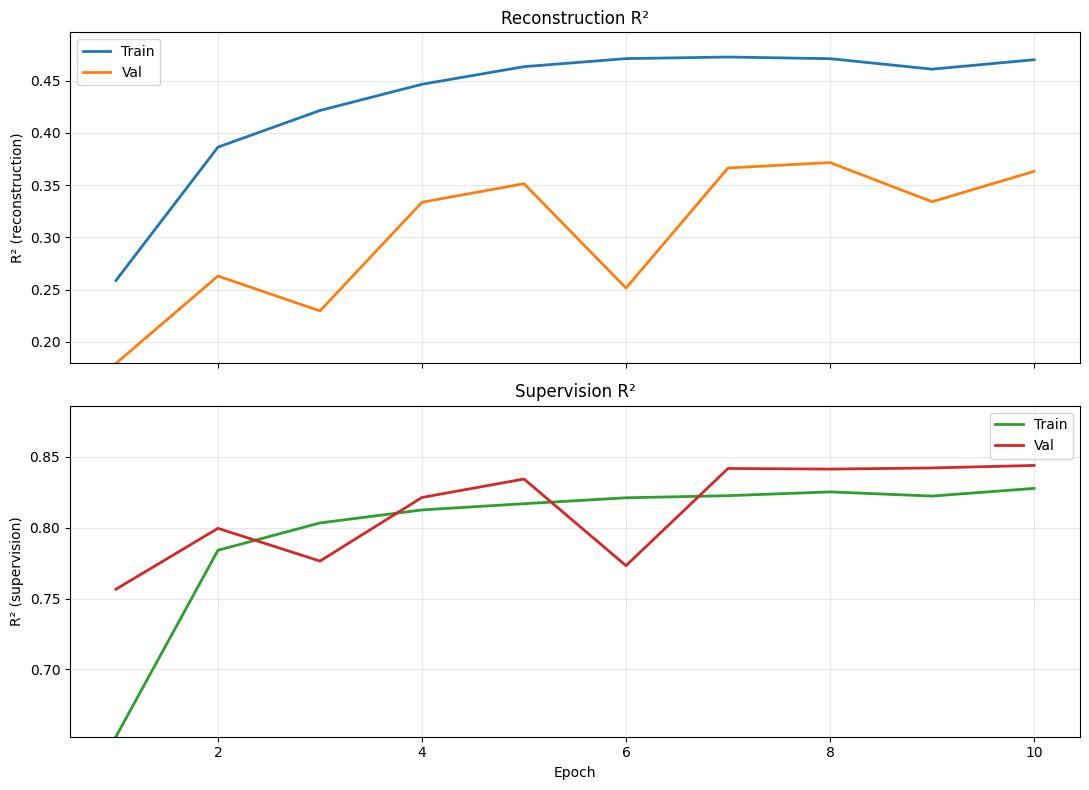


--- Training with alpha = 1 ---


 10%|█         | 1/10 [00:15<02:21, 15.72s/it]

Epoch 01 | loss=596.804 | R2_rec_train=0.2989 | R2_rec_val=0.2435 | R2_sup_train=0.6762 | R2_sup_val=0.7310


 20%|██        | 2/10 [00:30<02:01, 15.22s/it]

Epoch 02 | loss=456.436 | R2_rec_train=0.4284 | R2_rec_val=0.2570 | R2_sup_train=0.7869 | R2_sup_val=0.7626


 30%|███       | 3/10 [00:45<01:46, 15.17s/it]

Epoch 03 | loss=431.973 | R2_rec_train=0.4546 | R2_rec_val=0.3483 | R2_sup_train=0.8032 | R2_sup_val=0.7944


 40%|████      | 4/10 [01:01<01:32, 15.35s/it]

Epoch 04 | loss=412.745 | R2_rec_train=0.4795 | R2_rec_val=0.3204 | R2_sup_train=0.8111 | R2_sup_val=0.7655


 50%|█████     | 5/10 [01:17<01:17, 15.58s/it]

Epoch 05 | loss=406.567 | R2_rec_train=0.4862 | R2_rec_val=0.3908 | R2_sup_train=0.8152 | R2_sup_val=0.8096


 60%|██████    | 6/10 [01:33<01:02, 15.66s/it]

Epoch 06 | loss=398.450 | R2_rec_train=0.4965 | R2_rec_val=0.3967 | R2_sup_train=0.8189 | R2_sup_val=0.8237


 70%|███████   | 7/10 [01:48<00:46, 15.44s/it]

Epoch 07 | loss=392.904 | R2_rec_train=0.5039 | R2_rec_val=0.3763 | R2_sup_train=0.8208 | R2_sup_val=0.8263


 80%|████████  | 8/10 [02:04<00:31, 15.72s/it]

Epoch 08 | loss=390.255 | R2_rec_train=0.5069 | R2_rec_val=0.3785 | R2_sup_train=0.8224 | R2_sup_val=0.8356


 90%|█████████ | 9/10 [02:20<00:15, 15.98s/it]

Epoch 09 | loss=385.416 | R2_rec_train=0.5134 | R2_rec_val=0.2969 | R2_sup_train=0.8244 | R2_sup_val=0.8019


100%|██████████| 10/10 [02:36<00:00, 15.63s/it]

Epoch 10 | loss=386.848 | R2_rec_train=0.5100 | R2_rec_val=0.3799 | R2_sup_train=0.8250 | R2_sup_val=0.8232


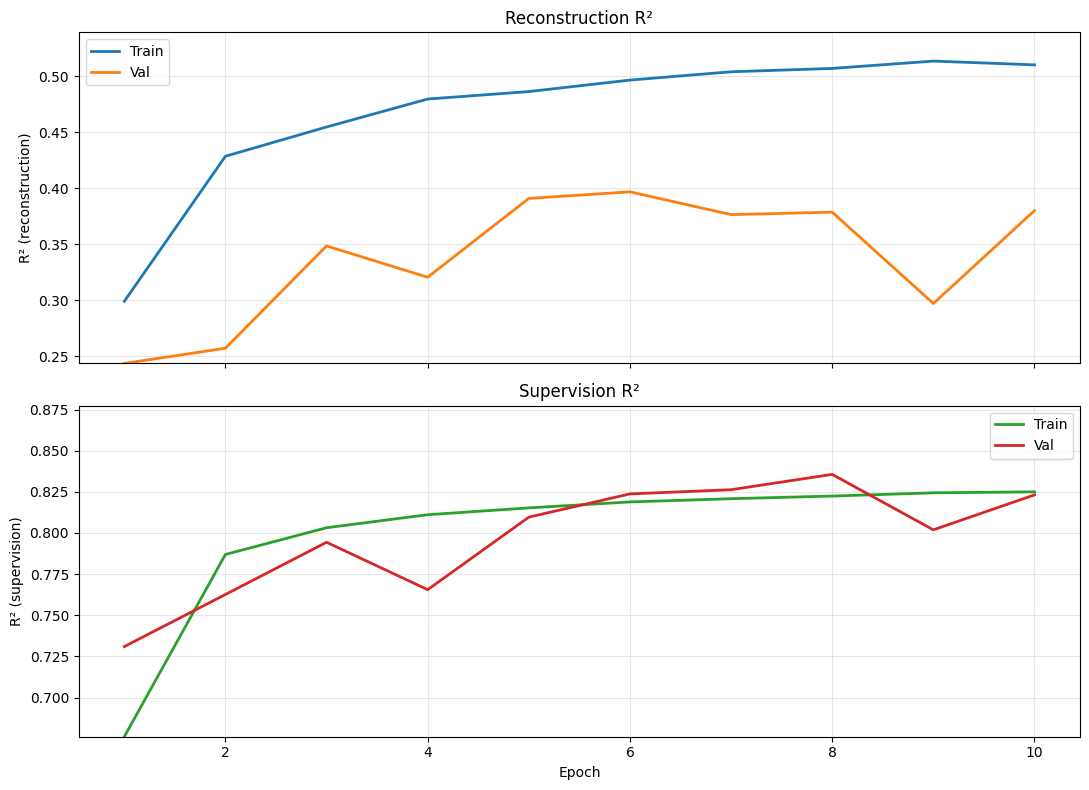


--- Training with alpha = 10 ---


 10%|█         | 1/10 [00:15<02:17, 15.32s/it]

Epoch 01 | loss=4070.705 | R2_rec_train=0.3271 | R2_rec_val=0.2590 | R2_sup_train=0.7338 | R2_sup_val=0.7258


 20%|██        | 2/10 [00:31<02:06, 15.77s/it]

Epoch 02 | loss=3358.241 | R2_rec_train=0.4409 | R2_rec_val=0.2477 | R2_sup_train=0.8205 | R2_sup_val=0.7313


 30%|███       | 3/10 [00:47<01:50, 15.79s/it]

Epoch 03 | loss=3256.714 | R2_rec_train=0.4582 | R2_rec_val=0.3427 | R2_sup_train=0.8220 | R2_sup_val=0.7626


 40%|████      | 4/10 [01:02<01:33, 15.67s/it]

Epoch 04 | loss=3114.485 | R2_rec_train=0.4829 | R2_rec_val=0.2248 | R2_sup_train=0.8224 | R2_sup_val=0.7511


 50%|█████     | 5/10 [01:17<01:17, 15.44s/it]

Epoch 05 | loss=3243.211 | R2_rec_train=0.4606 | R2_rec_val=0.3750 | R2_sup_train=0.8200 | R2_sup_val=0.7536


 60%|██████    | 6/10 [01:33<01:02, 15.52s/it]

Epoch 06 | loss=3012.652 | R2_rec_train=0.4996 | R2_rec_val=0.3544 | R2_sup_train=0.8248 | R2_sup_val=0.7648


 70%|███████   | 7/10 [01:48<00:46, 15.37s/it]

Epoch 07 | loss=2984.636 | R2_rec_train=0.5045 | R2_rec_val=0.4180 | R2_sup_train=0.8246 | R2_sup_val=0.7574


 80%|████████  | 8/10 [02:04<00:30, 15.45s/it]

Epoch 08 | loss=2921.060 | R2_rec_train=0.5154 | R2_rec_val=0.4014 | R2_sup_train=0.8253 | R2_sup_val=0.7472


 90%|█████████ | 9/10 [02:19<00:15, 15.51s/it]

Epoch 09 | loss=2952.471 | R2_rec_train=0.5103 | R2_rec_val=0.3053 | R2_sup_train=0.8249 | R2_sup_val=0.7334


100%|██████████| 10/10 [02:34<00:00, 15.45s/it]

Epoch 10 | loss=3065.706 | R2_rec_train=0.4909 | R2_rec_val=0.3718 | R2_sup_train=0.8231 | R2_sup_val=0.7603


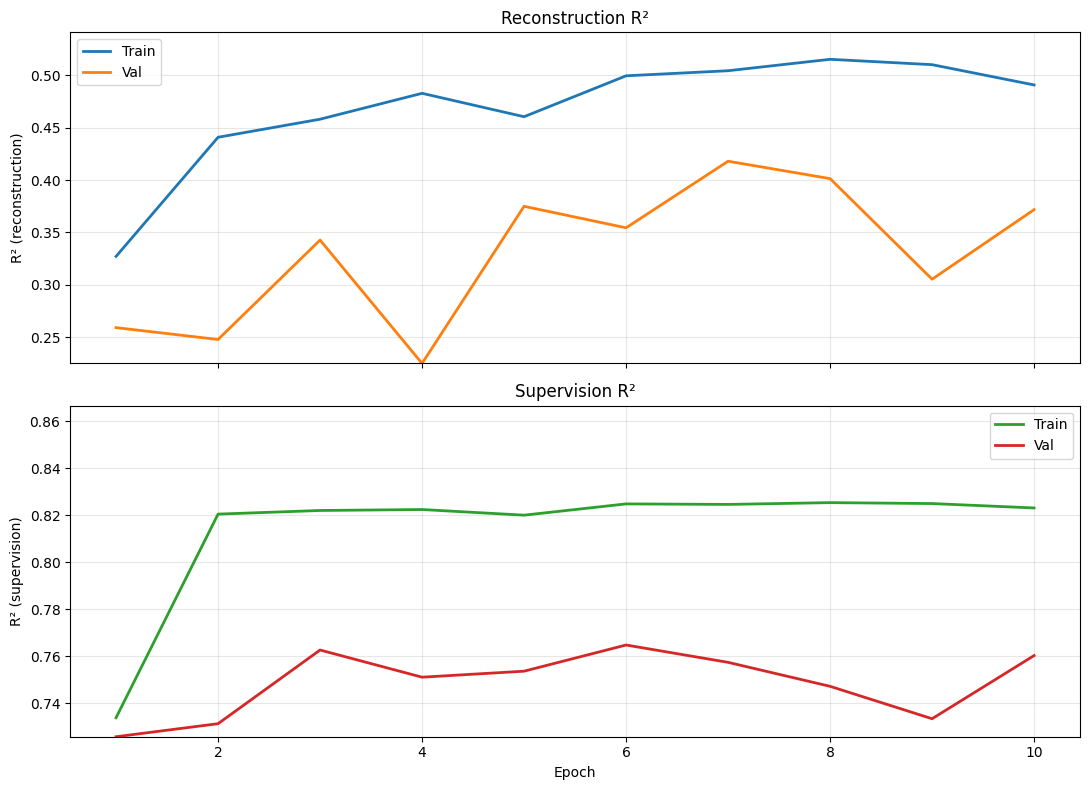

In [5]:
# define model parameters
n_feat = len(features)
n_latent = 16
encoder_hidden = [64, 32]
decoder_hidden = [32, 64]
head_hidden = [8, 8, 4]

def test(alpha):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Initialize model and move to device
    model = AutoEncoder(
        n_feat=n_feat,
        n_latent=n_latent,
        encoder_hidden=encoder_hidden,
        decoder_hidden=decoder_hidden,
        head_hidden=head_hidden,
    ).to(device) 

    # Optimization parameters
    lr = 0.5e-2 
    beta = 1.0

    optimizer = Adam(model.parameters(), lr=lr)
    criterion = CombinedLoss(alpha=alpha, beta=beta)
    n_epochs = 10

    history = train_model(
        model=model,
        train_loader=train_data_loader,
        val_loader=val_data_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        n_epochs=n_epochs,
    )
    return history

results = {}
for alpha in [0, 0.01, 0.1, 1, 10]:
    print(f"\n--- Training with alpha = {alpha} ---")
    results[alpha] = test(alpha)